# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor


In [3]:
train = pd.read_csv('Data/Grocery/sales_train.csv.gz', parse_dates=['date'])
shops = pd.read_csv('Data/Grocery/shops.csv')
items = pd.read_csv('Data/Grocery/items.csv')
test = pd.read_csv('Data/Grocery/test.csv.gz')

In [4]:
train.shape

(2935849, 6)

In [111]:
train.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id
0,0,0,32,1,2013,4.000000,2.666667,0.000000,1+1,40
1,0,0,32,3,2013,2.000000,2.666667,0.000000,1+1,40
2,0,0,33,1,2013,2.000000,1.500000,0.000000,1+1 (BD),37
3,0,0,33,3,2013,1.000000,1.500000,0.000000,1+1 (BD),37
4,0,0,35,1,2013,1.000000,1.875000,0.000000,10 ЛЕТ СПУСТЯ,40


Steps to improve model:
1. Knowing this in Russia, add the bank and the school holidays
2. check whether some items wherein specific discount and check sales relevant to them
3. Are same products sold for different prices in different stores
4. Do all stores hold all products, NO does this make a difference in the model
5. 

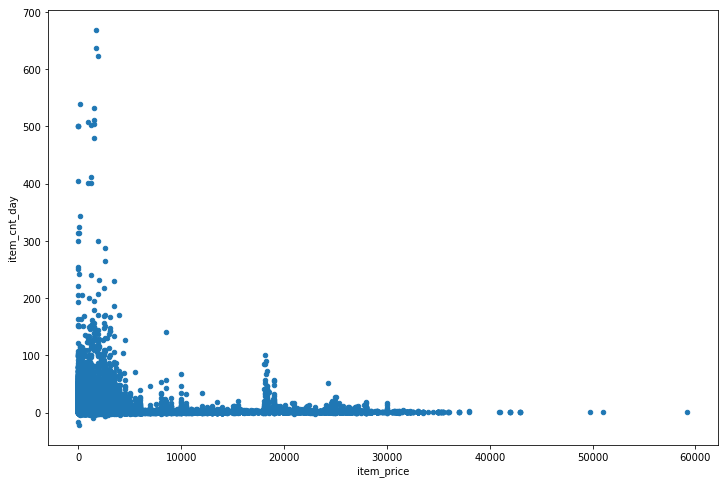

In [107]:
train[(train.item_price < 150000) & (train.item_cnt_day < 950)].plot('item_price', 'item_cnt_day', 'scatter',figsize=(12,8))

In [110]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train = train.drop(['date','item_price'], axis=1)
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})
#Monthly Mean
shop_item_monthly_mean = train[['shop_id','item_id','item_cnt_month']].groupby(['shop_id','item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})
#Add Mean Feature
train = pd.merge(train, shop_item_monthly_mean, how='left', on=['shop_id','item_id'])
#Last Month (Oct 2015)
shop_item_prev_month = train[train['date_block_num']==33][['shop_id','item_id','item_cnt_month']]
shop_item_prev_month = shop_item_prev_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})
shop_item_prev_month.head()
#Add Previous Month Feature
train = pd.merge(train, shop_item_prev_month, how='left', on=['shop_id','item_id']).fillna(0.)
#Items features
train = pd.merge(train, items, how='left', on='item_id')
#Item Category features
train = pd.merge(train, items, how='left', on='item_category_id')
#Shops features
train = pd.merge(train, shops, how='left', on='shop_id')

KeyError: 'date'

Merge with items to extract the category id

In [49]:
df_all = train.merge(items, on='item_id')

In [50]:
df_all = df_all.merge(shops, on='shop_id')

In [51]:
df_all.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name
0,2013-02-01,0,59,22154,999.000000,1.000000,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир"""
1,2013-05-16,4,59,2573,249.000000,1.000000,DEL REY LANA Born To Die,55,"Ярославль ТЦ ""Альтаир"""
2,2013-01-26,0,59,2574,399.000000,1.000000,DEL REY LANA Born To Die The Paradise Editio...,55,"Ярославль ТЦ ""Альтаир"""
3,2013-09-01,0,59,2574,399.000000,1.000000,DEL REY LANA Born To Die The Paradise Editio...,55,"Ярославль ТЦ ""Альтаир"""
4,2013-02-24,1,59,2574,399.000000,1.000000,DEL REY LANA Born To Die The Paradise Editio...,55,"Ярославль ТЦ ""Альтаир"""


In [52]:
df_raw = df_all.drop(['item_name', 'shop_name'], axis=1)

In [53]:
df_raw.shape

(2935849, 7)

In [54]:
df_raw.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-02-01,0,59,22154,999.000000,1.000000,37
1,2013-05-16,4,59,2573,249.000000,1.000000,55
2,2013-01-26,0,59,2574,399.000000,1.000000,55
3,2013-09-01,0,59,2574,399.000000,1.000000,55
4,2013-02-24,1,59,2574,399.000000,1.000000,55


In [55]:
pd.set_option('float_format', '{:f}'.format)

In [56]:
df_raw.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000,2935849.000000
mean,14.569911,33.001728,10197.227057,890.853233,1.242641,40.001383
std,9.422988,16.226973,6324.297354,1729.799631,2.618834,17.100759
min,0.000000,0.000000,0.000000,-1.000000,-22.000000,0.000000
25%,7.000000,22.000000,4476.000000,249.000000,1.000000,28.000000
50%,14.000000,31.000000,9343.000000,399.000000,1.000000,40.000000
75%,23.000000,47.000000,15684.000000,999.000000,1.000000,55.000000
max,33.000000,59.000000,22169.000000,307980.000000,2169.000000,83.000000


In [57]:
df_raw.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

In [60]:
date_att = ['day','dayofweek','dayofyear','days_in_month','is_month_end','is_month_start','is_quarter_end','is_quarter_start','is_year_end',
 'is_year_start','month','quarter','week','weekday','weekofyear','year']

for i in date_att:
    df_raw['sale_'+i] = getattr(df_raw['date'].dt, i)
df_raw.drop('date', axis = 1, inplace=True)

In [61]:
df_raw.shape

(2935849, 22)

In [62]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [63]:
display_all(df_raw.head())

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,sale_day,sale_dayofweek,sale_dayofyear,sale_days_in_month,sale_is_month_end,sale_is_month_start,sale_is_quarter_end,sale_is_quarter_start,sale_is_year_end,sale_is_year_start,sale_month,sale_quarter,sale_week,sale_weekday,sale_weekofyear,sale_year
0,0,59,22154,999.000000,1.000000,37,1,4,32,28,False,True,False,False,False,False,2,1,5,4,5,2013
1,4,59,2573,249.000000,1.000000,55,16,3,136,31,False,False,False,False,False,False,5,2,20,3,20,2013
2,0,59,2574,399.000000,1.000000,55,26,5,26,31,False,False,False,False,False,False,1,1,4,5,4,2013
3,0,59,2574,399.000000,1.000000,55,1,6,244,30,False,True,False,False,False,False,9,3,35,6,35,2013
4,1,59,2574,399.000000,1.000000,55,24,6,55,28,False,False,False,False,False,False,2,1,8,6,8,2013


# Preprocessing

Split the target variable from the rest of the dataset

In [21]:
def change_df(df, y, subset=False):
    if subset:
        df = df.sample(subset).copy()
    return df.drop(y, axis = 1), df[y]

In [22]:
df, y = change_df(df_raw, 'item_cnt_day')

In [23]:
def split_data(df, n):
    return df[:n].copy(), df[n:].copy()

In [24]:
# Take a test set of the same size of the test set on kaggle
test_size = 214200
n_size = len(df_raw) - test_size
df_trn, df_valid  = split_data(df_raw, n_size)
X_train, X_valid = split_data(df, n_size)
y_train, y_valid = split_data(y, n_size)

In [25]:
X_train.shape, y_train.shape, X_valid.shape

((2721649, 21), (2721649,), (214200, 21))

In [26]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [27]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train) , rmse(m.predict(X_valid), y_valid),
            m.score(X_train, y_train), m.score(X_valid, y_valid)]
    print(res)

In [28]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.8246529491637417, 7.808205504631873, 0.8937385846196146, -3.80940803383421]


## Base Model

In [29]:
df_base, y_base = change_df(df_raw, 'item_cnt_day', subset=30000)

In [45]:
X_trn_base, _ = split_data(df_base, 20000)
y_trn_base, _ = split_data(y_base, 20000)

In [46]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_trn_base, y_trn_base)
print_score(m)

[2.503888735975627, 3.595632089588276, 0.020367428779278218, -0.019857865807203945]


In [47]:
import IPython
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import re

def draw_tree(t, df,  size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s)))

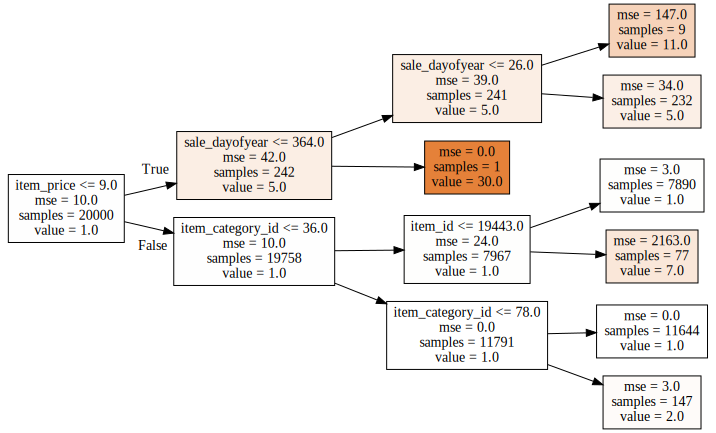

In [48]:
draw_tree(m.estimators_[0] , df_base)